In [1]:
# addprocs(7)  # parallel computing

In [2]:
include("prepare_data_Sioux_simp.jl");
include("extract_data.jl");
include("tap_MSA_Sioux_simp.jl");
include("inverseVI.jl");
include("demands_adjustment_Sioux_simp_gradi.jl");

In [3]:
tapFlowVecDict = Dict{Int64, Array{Float64, 1}}();
tapFlowDicDict = Dict{Int64, Dict{(Int64,Int64),Float64}}();
arcsDict = Dict{Int64, Dict{(Int, Int), Arc}}();
coeffs_dict = Dict{(Int64,Float64,Float64,Int64),Array{Float64,1}}();
jacobDict = Dict{Int64, Array{Float64}}();
descDirecDict = Dict{Int64, Array{Float64,1}}();
searchDirecDict = Dict{Int64, Array{Float64,1}}();
demandsVecDict = Dict{Int64, Array{Float64,1}}();
thetaMaxDict = Dict{Int64, Float64}();
objFunDict = Dict{Int64, Float64}();
norObjFunDict = Dict{Int64, Float64}();
objInvVIDict = Dict{Int64, Float64}();
demandsDiffDict = Dict{Int64, Float64}();

In [4]:
demandsDiffDict[1] = norm(demandsDicToVec(demandsDict[1]) - demandsDicToVec(demandsDict[0]))/
norm(demandsDicToVec(demandsDict[0]));

In [5]:
fcoeffs = [1, 0, 0, 0, .15];

# get observed flow vector (corresponding to ground truth demands and ground truth costs)
tapFlowDicDict[0], tapFlowVecDict[0] = tapMSA(demandsDict[0], fcoeffs);

In [6]:
# get arcs data corresponding to ground truth demands and flows
arcsDict[0] = observFlow("../data_original/SiouxFalls_net_simp.txt", tapFlowDicDict[0]);

In [7]:
deg = 6
c = 3.41
lam = 1.

coeffs_dict[(deg, c, lam, 1)], objInvVIDict[1] = train(lam, deg, c, demandsDict[1], arcsDict[0]);

In [8]:
# get initial flow vector (corresponding to initial demands)
tapFlowDicDict[1], tapFlowVecDict[1] = tapMSA(demandsDict[1], coeffs_dict[(deg, c, lam, 1)]);

demandsVecDict[0] = demandsDicToVec(demandsDict[0]);

In [9]:
# get arcs data corresponding to initial demands and flows
arcsDict[1] = observFlow("../data_original/SiouxFalls_net_simp.txt", tapFlowDicDict[1]);

In [10]:
# number of iterations
N = 19;  

In [11]:
for iterNumber = 1:N
    
    l = iterNumber;
    
    jacobDict[l] = jacobian(tapFlowVecDict[l], coeffs_dict[(deg, c, lam, l)], capacity, 
    free_flow_time, numLinks, numODpairs, numRoutes, linkRoute, odPairRoute);

    descDirecDict[l] = descDirec(tapFlowVecDict[l], tapFlowVecDict[0], jacobDict[l], numODpairs, numLinks);

    demandsVecDict[l] = demandsDicToVec(demandsDict[l]);

    searchDirecDict[l] = searchDirec(demandsVecDict[l], descDirecDict[l], 0);

    thetaMaxDict[l] = thetaMax(demandsVecDict[l], searchDirecDict[l]);

    objFunDict[l] = objF(demandsVecDict[l]);

    demandsVecDict[l+1] = similar(demandsVecDict[0]);
    
    demandsVecDict[l+1], objFunDict[l+1] = armijo(demandsVecDict[l], searchDirecDict[l], thetaMaxDict[l], 4, 3);
            
    demandsDict[l+1] = demandsVecToDic(demandsVecDict[l+1]);
    
    tapFlowDicDict[l+1], tapFlowVecDict[l+1] = tapMSA(demandsDict[l+1], coeffs_dict[(deg, c, lam, l)]);
    
    arcsDict[l+1] = observFlow("../data_original/SiouxFalls_net_simp.txt", tapFlowDicDict[l+1]);
    
    coeffs_dict[(deg, c, lam, l+1)], objInvVIDict[l+1] = train(lam, deg, c, demandsDict[l+1], arcsDict[l+1]);
    
    demandsDiffDict[l+1] = norm(demandsVecDict[l+1] - demandsVecDict[0]) / norm(demandsVecDict[0]);
        
end

# normalize objective function value
for l = 1:(N+1)
    norObjFunDict[l] = objFunDict[l] / objFunDict[1]
end

In [12]:
demandsVecDict

Dict{Int64,Array{Float64,1}} with 21 entries:
  18 => [122.25331076758887,93.22812479349747,586.4243314743737,214.988837790756…
  2  => [101.23726838586359,100.87182272006065,530.2715328061813,207.94634771672…
  16 => [122.25331076758887,93.22812479349747,586.4243314743737,214.988837790756…
  11 => [122.25331076758887,93.22812479349747,586.4243314743737,214.988837790756…
  0  => [100.0,100.0,500.0,200.0,300.0,500.0,800.0,500.0,1300.0,500.0,200.0,100.…
  7  => [122.25331076758887,93.22812479349747,586.4243314743737,214.988837790756…
  9  => [122.25331076758887,93.22812479349747,586.4243314743737,214.988837790756…
  10 => [122.25331076758887,93.22812479349747,586.4243314743737,214.988837790756…
  19 => [122.25331076758887,93.22812479349747,586.4243314743737,214.988837790756…
  17 => [122.25331076758887,93.22812479349747,586.4243314743737,214.988837790756…
  8  => [122.25331076758887,93.22812479349747,586.4243314743737,214.988837790756…
  6  => [121.22912714707508,94.0820623005108,583.554

In [13]:
norObjFunDict

Dict{Int64,Float64} with 20 entries:
  18 => 0.8506461278000877
  2  => 0.8941320946290474
  16 => 0.8506461278000877
  11 => 0.8506461278000877
  7  => 0.8506461278000877
  9  => 0.8506461278000877
  10 => 0.8506461278000877
  19 => 0.8506461278000877
  17 => 0.8506461278000877
  8  => 0.8506461278000877
  6  => 0.85198361458774
  4  => 0.8586669217421863
  3  => 0.8683744076227091
  5  => 0.8538738614365203
  20 => 0.8506461278000877
  13 => 0.8506461278000877
  14 => 0.8506461278000877
  15 => 0.8506461278000877
  12 => 0.8506461278000877
  1  => 1.0

INFO: Loading help data...


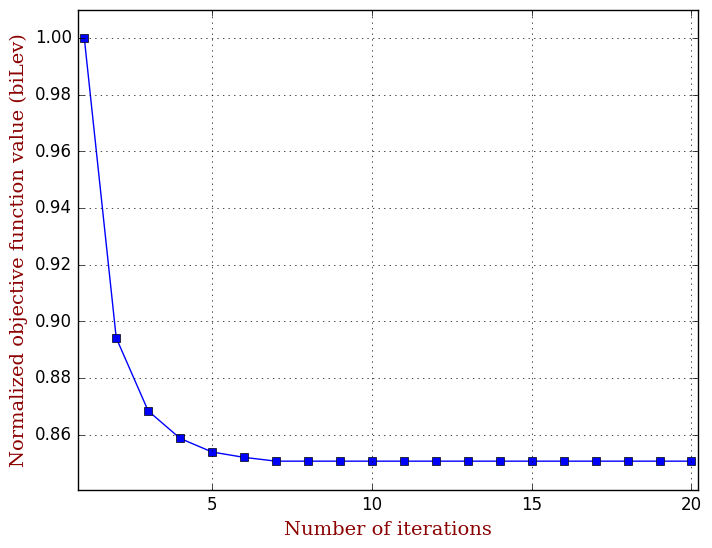

In [14]:
using PyPlot

iterNum = 1:(N+1)

objFun = map(iterNum->norObjFunDict[iterNum], iterNum)

# plot(iterNum, objFun, "s-g", label="True")

plot(iterNum, objFun, "s-b")

# legend(loc="upper right",fancybox="true") 

grid("on")

xlim(.8, N + 1 + .2)
ylim(minimum(objFun)-.01, maximum(objFun)+.01)

font1 = ["family"=>"serif", "color"=>"darkred", "weight"=>"normal", "size"=>14]

xlabel("Number of iterations", fontdict=font1)
ylabel("Normalized objective function value (biLev)", fontdict=font1)

savefig("objFun_biLev_Sioux_simp.pdf")

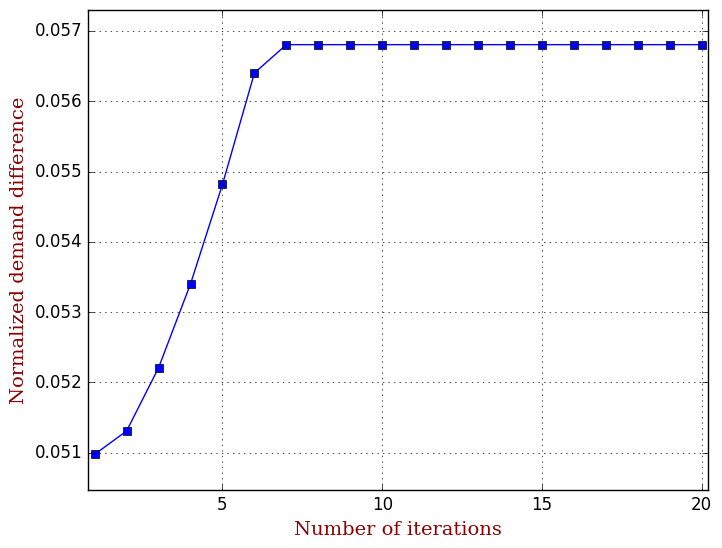

In [15]:
using PyPlot

iterNum = 1:(N+1)

demandsDiff = map(iterNum->demandsDiffDict[iterNum], iterNum)

# plot(iterNum, objFun, "s-g", label="True")

plot(iterNum, demandsDiff, "s-b")

# legend(loc="upper right",fancybox="true") 

grid("on")

xlim(.8, N + 1 + .2)
ylim(minimum(demandsDiff)-.0005, maximum(demandsDiff)+.0005)

font1 = ["family"=>"serif", "color"=>"darkred", "weight"=>"normal", "size"=>14]

xlabel("Number of iterations", fontdict=font1)
ylabel("Normalized demand difference", fontdict=font1)

savefig("demandsDiff_biLev_Sioux_simp.pdf")

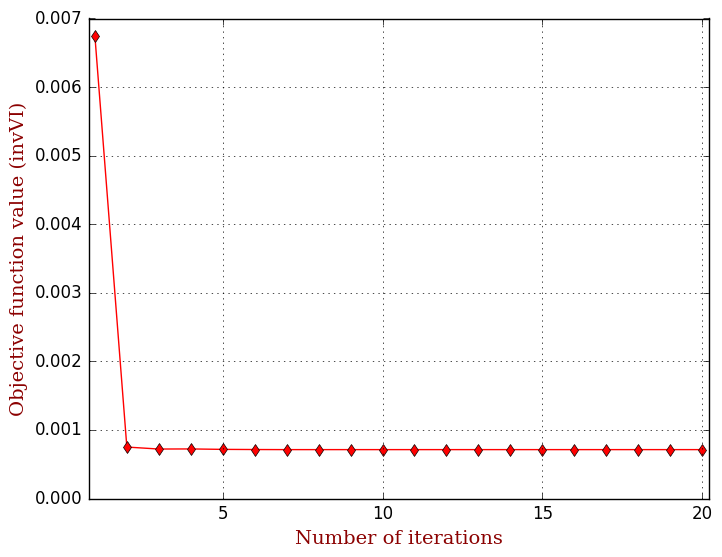

In [16]:
using PyPlot

iterNum = 1:(N+1)

objFun = map(iterNum->objInvVIDict[iterNum], iterNum)

# plot(iterNum, objFun, "s-g", label="True")

plot(iterNum, objFun, "d-r")

# legend(loc="upper right",fancybox="true") 

grid("on")

xlim(0.8, N + 1 + .2)
# ylim(0.9, 2.0)

font1 = ["family"=>"serif", "color"=>"darkred", "weight"=>"normal", "size"=>14]

xlabel("Number of iterations", fontdict=font1)
ylabel("Objective function value (invVI)", fontdict=font1)

savefig("objFun_invVI_Sioux_simp.pdf")

In [17]:
coeffs_dict

Dict{(Int64,Float64,Float64,Int64),Array{Float64,1}} with 20 entries:
  (6,3.41,1.0,6)  => [1.0,0.007307702208684156,-0.04973174884216117,0.0985799523…
  (6,3.41,1.0,11) => [1.0,0.00969214418306701,-0.06261837365228257,0.12031647252…
  (6,3.41,1.0,20) => [1.0,0.00969214418306701,-0.06261837365228257,0.12031647252…
  (6,3.41,1.0,13) => [1.0,0.00969214418306701,-0.06261837365228257,0.12031647252…
  (6,3.41,1.0,3)  => [1.0,0.007205036962829322,-0.04955552081169317,0.0998356686…
  (6,3.41,1.0,10) => [1.0,0.00969214418306701,-0.06261837365228257,0.12031647252…
  (6,3.41,1.0,8)  => [1.0,0.009689922582411846,-0.06260609428801753,0.1202948687…
  (6,3.41,1.0,15) => [1.0,0.00969214418306701,-0.06261837365228257,0.12031647252…
  (6,3.41,1.0,14) => [1.0,0.00969214418306701,-0.06261837365228257,0.12031647252…
  (6,3.41,1.0,19) => [1.0,0.00969214418306701,-0.06261837365228257,0.12031647252…
  (6,3.41,1.0,17) => [1.0,0.00969214418306701,-0.06261837365228257,0.12031647252…
  (6,3.41,1.0,9)  => [1.0,0.

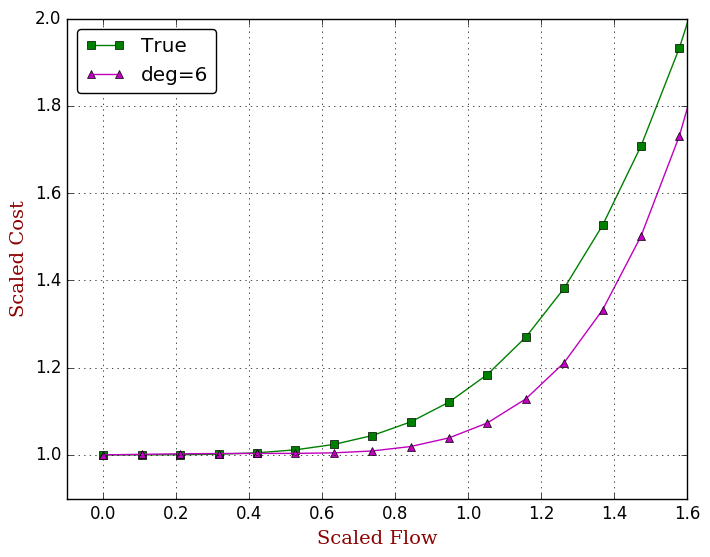

In [18]:
using PyPlot

iterN = 1

true_coeffs = [1, 0, 0, 0, .15]
# true_coeffs = [1, .2, .5, .8, .15]

est_coeffs = coeffs_dict[(6, 3.41, 1., iterN)]

xs = linspace(0, 2, 20)
zs_true = map(x->polyEval(true_coeffs, x), xs)

zs = map(x->polyEval(est_coeffs, x), xs)

plot(xs, zs_true, "s-g", label="True")

plot(xs, zs, "^-m", label="deg=6")
legend(loc="upper left",fancybox="true") 

grid("on")
xlim(-0.1, 1.6);
ylim(0.9, 2.0);

font1 = ["family"=>"serif","color"=>"darkred","weight"=>"normal","size"=>14]
xlabel("Scaled Flow", fontdict=font1)
ylabel("Scaled Cost", fontdict=font1)

savefig("fitting_Sioux_simp_iter_$(iterN).pdf")

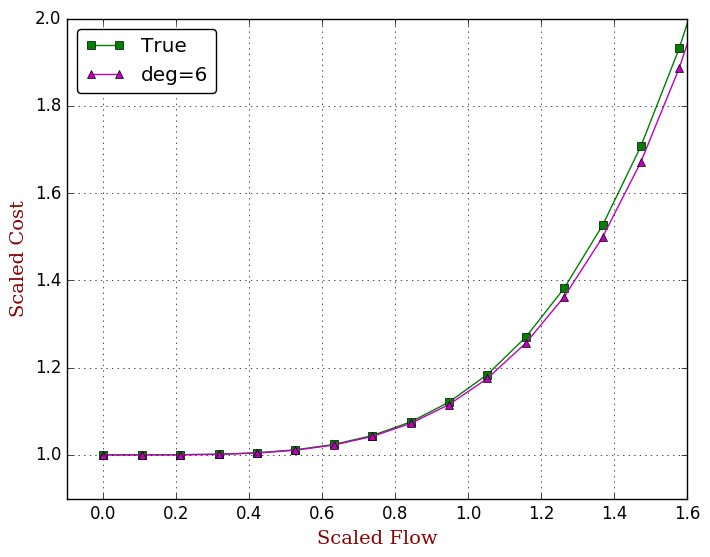

In [19]:
using PyPlot

iterN = 2

true_coeffs = [1, 0, 0, 0, .15]
# true_coeffs = [1, .2, .5, .8, .15]

est_coeffs = coeffs_dict[(6, 3.41, 1., iterN)]

xs = linspace(0, 2, 20)
zs_true = map(x->polyEval(true_coeffs, x), xs)

zs = map(x->polyEval(est_coeffs, x), xs)

plot(xs, zs_true, "s-g", label="True")

plot(xs, zs, "^-m", label="deg=6")
legend(loc="upper left",fancybox="true") 

grid("on")
xlim(-0.1, 1.6);
ylim(0.9, 2.0);

font1 = ["family"=>"serif","color"=>"darkred","weight"=>"normal","size"=>14]
xlabel("Scaled Flow", fontdict=font1)
ylabel("Scaled Cost", fontdict=font1)

savefig("fitting_Sioux_simp_iter_$(iterN).pdf")

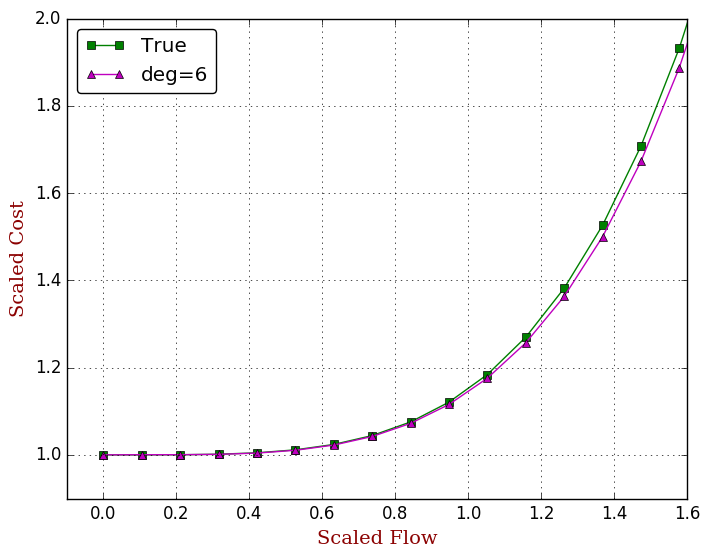

In [20]:
using PyPlot

iterN = 3

true_coeffs = [1, 0, 0, 0, .15]
# true_coeffs = [1, .2, .5, .8, .15]

est_coeffs = coeffs_dict[(6, 3.41, 1., iterN)]

xs = linspace(0, 2, 20)
zs_true = map(x->polyEval(true_coeffs, x), xs)

zs = map(x->polyEval(est_coeffs, x), xs)

plot(xs, zs_true, "s-g", label="True")

plot(xs, zs, "^-m", label="deg=6")
legend(loc="upper left",fancybox="true") 

grid("on")
xlim(-0.1, 1.6);
ylim(0.9, 2.0);

font1 = ["family"=>"serif","color"=>"darkred","weight"=>"normal","size"=>14]
xlabel("Scaled Flow", fontdict=font1)
ylabel("Scaled Cost", fontdict=font1)

savefig("fitting_Sioux_simp_iter_$(iterN).pdf")